In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

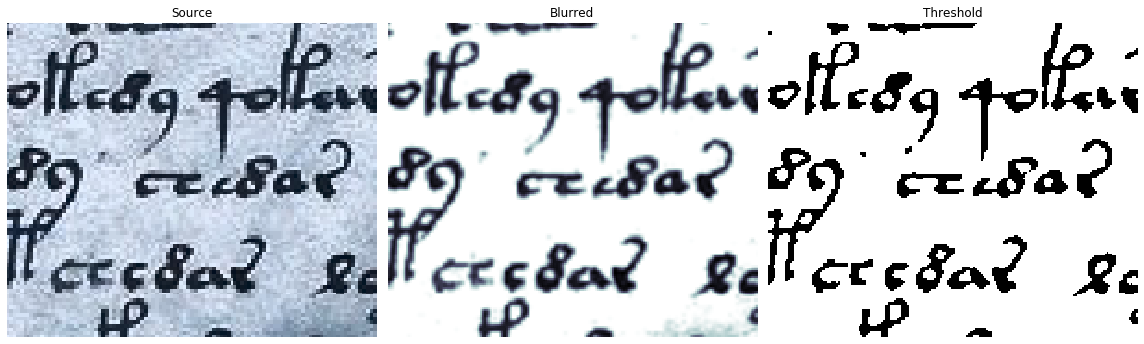

In [2]:
pth = '/home/tony/voynich/png/easy/clean/'
fn = 'img-203c.png'
image = cv2.imread(pth+fn)

kernel = np.ones((1, 1), np.uint8)

def clean(img):
    img = cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)
    img = cv2.multiply(img, 1.5)
    blr = cv2.GaussianBlur(img, (3, 3), 0)
    thres = cv2.adaptiveThreshold(blr, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 40)
    thres = cv2.dilate(thres, kernel, iterations=1)
    return  [blr, thres]
    
gray, thresh = clean(image)

_, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].imshow(image[300:470,500:700], cmap=plt.cm.bone)
axs[0].set_title('Source')
axs[1].imshow(gray[300:470,500:700], cmap=plt.cm.bone)
axs[1].set_title('Blurred')
axs[2].imshow(thresh[300:470,500:700], cmap=plt.cm.bone)
axs[2].set_title('Threshold')

for ax in axs:
        ax.axis('off')
        
plt.tight_layout()
plt.show()

In [237]:
Gmx = 120 
Gmn = 12 

def fits(b):
    return b[2] > Gmn and b[3] > Gmn and b[2] < Gmx-2 and b[3] < Gmx-2 and b[0] > 0 and b[1] > 0
    
def cut(img, b, c):
    roi = img[b[1]-1:b[1]+b[3]+2, b[0]-1:b[0]+b[2]+2]
    hc, wc = roi.shape
    delta_w = Gmx - wc
    delta_h = Gmx - hc
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    mask = 255 * np.ones(shape=[hc, wc], dtype=np.uint8)
    mask = cv2.drawContours(mask, [ c - ( b[0] - 1, b[1] - 1 ) ], -1, 0,-1)
    masked = np.where(mask==0, roi, 255)
    masked = cv2.GaussianBlur(masked, (5, 5), 0)
    masked = cv2.copyMakeBorder(masked, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    return masked


clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))

def parse(path, src):
    a = []
    i = 0
    image = cv2.imread(path+src)
    gray, thresh = clean(image)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        bound = cv2.boundingRect(contour)
        if fits(bound):
            mask = cut(gray, bound, contour)
            #mask = cv2.equalizeHist(mask)
            mask = clahe.apply(mask)
            a.append([i, src, mask, bound, contour])
            i+=1
    return a

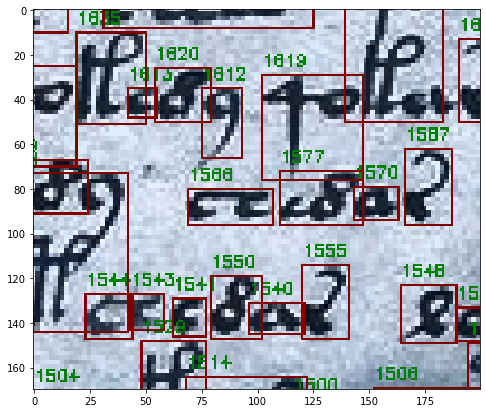

In [238]:
result = parse(pth, fn)

#width, height = image.shape[0:2]
#dsize = (width, height)
#image = cv2.resize(image, dsize)

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.25
color = (0, 128, 0) 
thickness = 1

imageCopy = image.copy()
for id, src, mask, bound, contour in result:
    x,y,w,h = bound
    imageA = cv2.rectangle(imageCopy, (x,y), (x+w, y+h),(128,0,0), 1)
    imageA = cv2.putText(imageCopy, str(id), (x, y-4), font, fontScale, color, thickness) 

_, axs = plt.subplots(1, 1, figsize=(8,8))
axs.imshow(imageCopy[300:470,500:700], alpha=1)
ax.axis('off')
plt.show()

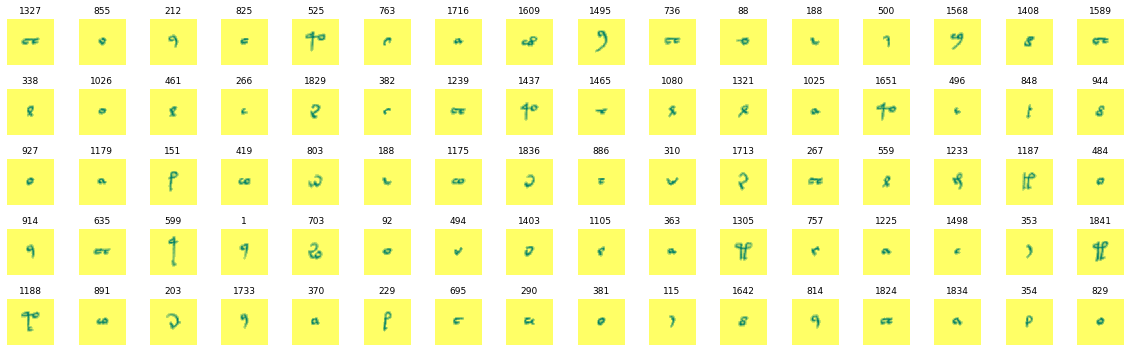

In [239]:
import random

r,c = (5,16)
_, axs = plt.subplots(r, c, figsize=(c,r))
for i,r in [(_,random.randrange(len(result))) for _ in range(r*c)]:
    id, src, mask, bound, contour = result[r]
    ax = axs[int(i/c), i%c]
    ax.imshow(mask, cmap=plt.cm.summer)
    ax.set_title(r, fontsize=9)
    ax.axis('off')
plt.tight_layout()

In [240]:
key_size = 60

pca_data = []
images =[]
for id, src, mask, bound, contour in result:
    pca_data.append(cv2.resize(mask, (key_size, key_size)).flatten())
    images.append(mask)

In [241]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_components = 32

scaler = StandardScaler()
scaler.fit(pca_data)
sdt = scaler.transform(pca_data)
pca = PCA(n_components = n_components, copy=True, whiten=True)
projected = pca.fit_transform(sdt)
EPR = pca.explained_variance_ratio_

print('Components:', len(EPR))
print(np.round(EPR[:10]*100, 1))
print(str(np.round(sum(EPR[:10])*100,2))+'%')

Components: 32
[13.1  8.4  7.1  6.1  5.7  5.   4.   3.6  3.   2.9]
58.78%


In [242]:
from sklearn.cluster import KMeans

n_clusters_ = 50

kmeans = KMeans( n_clusters=n_clusters_, max_iter=500, n_init=50).fit(projected)

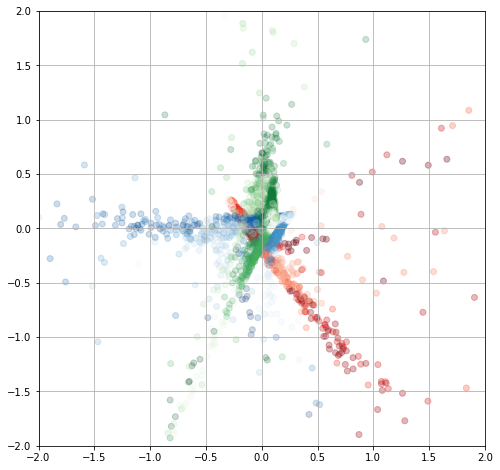

In [243]:
_, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.scatter(projected[:, 0], projected[:, 1], c=kmeans.labels_, alpha=0.3, cmap='Reds') 
axs.scatter(projected[:, 1], projected[:, 2], c=kmeans.labels_, alpha=0.2, cmap='Blues') 
axs.scatter(projected[:, 2], projected[:, 3], c=kmeans.labels_, alpha=0.2, cmap='Greens') 
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.show()

In [244]:
q={}
for img, lbl in zip(images, kmeans.labels_):
    if not lbl in q:
        q[lbl] = [img]
    else:
        q[lbl].append(img)
for k in sorted(q.keys()):
    if(len(q[k])) > 1:
        print(k,len(q[k]))

0 370
1 250
6 34
14 50
15 52
17 6
19 11
20 331
23 4
24 4
25 3
26 29
27 2
29 9
30 222
33 47
35 22
37 4
38 149
39 4
40 153
42 2
43 21
44 23
46 3
47 2
48 13
49 4


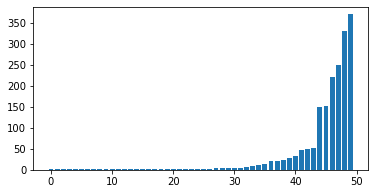

In [245]:
_, axs = plt.subplots(1, 1, figsize=(6,3))
k = sorted([len(q[k]) for k in q.keys()])
axs.bar(range(len(q.keys())), k)
plt.show()

50


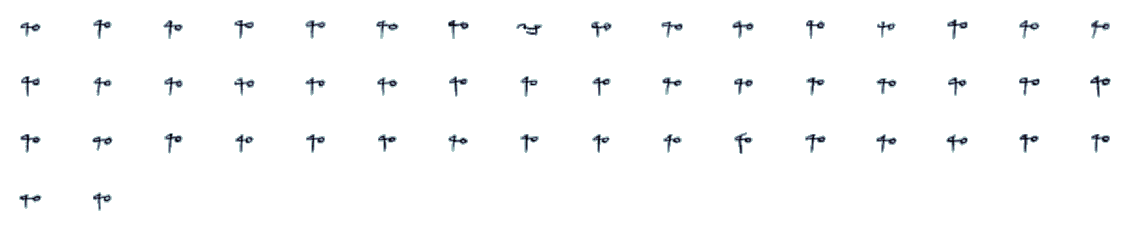

In [246]:
r,c = (8,16)
clst = q[14]
print(len(clst))
plt.figure(figsize=(c, len(clst)/15))
for i, img in enumerate(clst):
    plt.subplot(len(clst) / c + 1, c, i + 1)
    plt.imshow(img, cmap=plt.cm.bone)
    plt.gca().set_axis_off()
plt.tight_layout()
plt.show()

In [247]:
import matplotlib.colors as mc
import os

colors= np.random.rand(101)
cmap=plt.cm.hsv
c=cmap(colors)

imgs = []
s = """
<!DOCTYPE html>
<html>
<head>
<title>Clusters</title>
</head>
<body>
"""
ki = 0
for k in sorted(q.keys()):
    os.system("mkdir /var/www/html/voy/bins/" + str(k))   
    clst = q[k]
    #s+='<div style="background-color:'+mc.to_hex(c[ki])+'">'
    s+='<div style="background-color:#EFEFEF">'
    s+="<p>" + str(k) + "</p>"
    for n,img in enumerate(clst):
        pp = "bins/" + str(k) + "/" + str(k) + "_" + str(n)+ ".png"
        ip = "/var/www/html/voy/bins/" + str(k) + "/" + str(k) + "_" + str(n)+ ".png"
        cv2.imwrite(  ip  , img )
        s += '<img src="'+pp+'" >'
    s+='</div>'
    ki += 1
s+= """
</body>
</html>
"""

f = open("/var/www/html/voy/voy.html", "w")
f.write(s)
f.close()